In [11]:
#!pip install scikit-surprise

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from google.colab import drive
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy



## 1. Data Analysis:
####     Load the provided dataset (CSV file) containing customer purchase history. The dataset includes:
        * Customer ID
        * Product ID
        * Product Category
        * Purchase Amount
        * Purchase Date

In [13]:
# Step 1: Here, I mounted the Google Drive
drive.mount('/content/drive')

# Step 2: then defined the file path in Google Drive where I stored the file
file_path = '/content/drive/My Drive/Dataset_AI_BookedBy/synthetic_purchase_data.csv'

try:
    # Step 3: here I tried to load the existing dataset from Google Drive, if it is saved when someone else is running
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully from Google Drive.")

except FileNotFoundError:
    # and if the file doesn't exist, I will generate the dataset instead of throwing an error
    print("Dataset not found. Generating a new dataset...")

    # setting random seed for reproducibility and consistenncy
    np.random.seed(42)
    random.seed(42)

    # the required parameters as was given in the question, I multiplied those numbers by 10 times to have a slightly bigger dataset than was expected
    num_customers = 5000
    num_products = 500
    num_records = 50000

    # generatedd unique customer IDs of the format something like C0001, C0002 etc
    customer_ids = [f'C{str(i).zfill(4)}' for i in range(1, num_customers + 1)]

    # then generated product IDs and categories and mapped product IDs to randome categories by using a dictionary
    product_ids = [f'P{str(i).zfill(3)}' for i in range(1, num_products + 1)]
    product_categories = [f'Category_{i}' for i in range(1, 11)]  # 10 categories
    product_id_to_category = {pid: random.choice(product_categories) for pid in product_ids}

    # generated purchase records, the flow is like this:
    # randomly generate customer and product IDs, then product_id is assigned to its category by retrieveing it from the dictionary 'product_id_to_category'
    # then, a random floating number is generated to between $5 and $500 to represent the purchase amount, then random number of days are generated betn jan 1 2023 - dec 31 2023
    # lastly, the generated record's are appended to the list records = []
    records = []
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)

    for _ in range(num_records):
        customer_id = random.choice(customer_ids)
        product_id = random.choice(product_ids)
        product_category = product_id_to_category[product_id]
        purchase_amount = round(np.random.uniform(5, 500), 2)  # Purchase amount between $5 and $500
        purchase_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
        records.append([customer_id, product_id, product_category, purchase_amount, purchase_date])

    # creating DataFrame for good visual effect
    df = pd.DataFrame(records, columns=['Customer ID', 'Product ID', 'Product Category', 'Purchase Amount', 'Purchase Date'])

    # saved the new dataset to Google Drive, if the dataset was not already present
    df.to_csv(file_path, index=False)
    print(f"New dataset generated and saved to {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully from Google Drive.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# loaded the dataset
df = pd.read_csv('/content/drive/My Drive/Dataset_AI_BookedBy/synthetic_purchase_data.csv')

# Analysis: identified top-selling products based on total purchase amount
top_selling_products = df.groupby('Product ID')['Purchase Amount'].sum().sort_values(ascending=False).head(10)

# Analysis: identified top-selling categories based on sales
top_selling_categories = df.groupby('Product Category')['Purchase Amount'].sum().sort_values(ascending=False).head(10)

# Analysis: calc. average spending per customer
average_spending_per_customer = df.groupby('Customer ID')['Purchase Amount'].mean().sort_values(ascending=False)

# displayed Results
print("Top-Selling Products:")
print(top_selling_products)

print("\nTop-Selling Categories:")
print(top_selling_categories)

print("\nAverage Spending Per Customer:")
print(average_spending_per_customer.head(10))  # the top 10 customers with the highest average spending

Top-Selling Products:
Product ID
P058    33092.70
P012    32814.99
P263    32048.34
P246    31987.99
P444    31680.16
P341    31626.34
P285    31513.55
P061    31312.79
P048    30941.16
P041    30783.59
Name: Purchase Amount, dtype: float64

Top-Selling Categories:
Product Category
Category_4     1555215.38
Category_2     1495860.32
Category_9     1436300.38
Category_5     1320280.76
Category_7     1297327.27
Category_1     1170917.17
Category_6     1170512.13
Category_3     1108193.22
Category_10    1097299.31
Category_8      944963.23
Name: Purchase Amount, dtype: float64

Average Spending Per Customer:
Customer ID
C4360    459.045000
C0914    453.833333
C3790    452.835000
C1403    424.725000
C3991    419.628333
C3576    418.380000
C2457    412.330000
C1948    411.065000
C4603    410.104000
C3878    410.014286
Name: Purchase Amount, dtype: float64


### 2. Customer Classification:
    * Use clustering (e.g., k-means) to group customers into segments based on their purchase behavior (e.g., frequency, total spending, product preferences).
    * Label the clusters with intuitive names (e.g., "High Spenders," "Occasional Buyers").

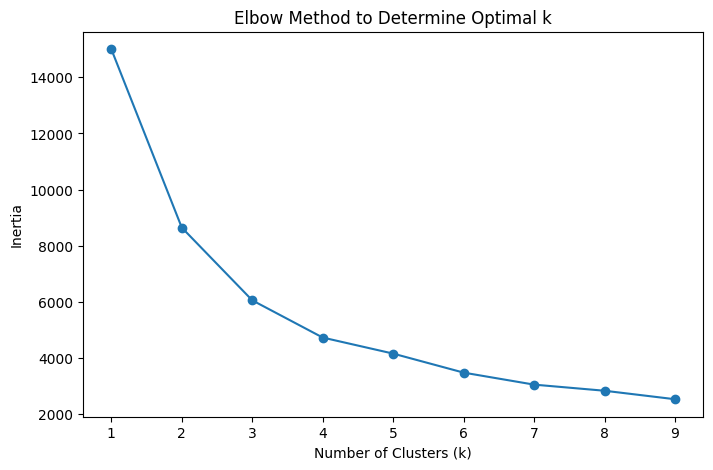

Cluster 0: Total Spending=2057.65, Frequency=8.49, Recency=25.14
Cluster 1: Total Spending=3458.16, Frequency=13.23, Recency=23.02
Cluster 2: Total Spending=1720.45, Frequency=6.94, Recency=109.10
   Customer ID  total_spending  frequency  recency           cluster_label
0        C0001         3429.72         11       52           High Spenders
1        C0002         2046.70          9        6  Frequent Recent Buyers
2        C0003         1488.99          9        9  Frequent Recent Buyers
3        C0004         2633.69          9       16  Frequent Recent Buyers
4        C0005         2222.82         10        3  Frequent Recent Buyers
5        C0006         3210.32         12       26           High Spenders
6        C0007         2088.67          8       16  Frequent Recent Buyers
7        C0008         2118.07          7       37  Frequent Recent Buyers
8        C0009         2171.84          7       23  Frequent Recent Buyers
9        C0010         2681.95         11       20  F

In [17]:
# Step 1: firstly the data needs to be prepared
# converting 'Purchase Date' to datetime for easier calculations
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# defining a reference date for recency calculation (e.g., the most recent purchase date in the dataset)
reference_date = df['Purchase Date'].max()

# aggregating features for each customer
customer_data = df.groupby('Customer ID').agg(
    total_spending=('Purchase Amount', 'sum'),
    frequency=('Purchase Amount', 'count'),
    recency=('Purchase Date', lambda x: (reference_date - x.max()).days)  # days since the last purchase
).reset_index()

# Step 2: scaling the data to have 0 mean and unit variance, ensuring all features contribute equaly to the clustering algo.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['total_spending', 'frequency', 'recency']])

# Step 3: determining the optimal number of clusters using the elbow method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# plottng the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

# Step 4: applying k-means clustering (choosing k=3 as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_data)

# Step 5: labeling the clusters with intuitive names
# analyze the clusters' statistics to assign names
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Total Spending={center[0]:.2f}, Frequency={center[1]:.2f}, Recency={center[2]:.2f}")

# assign names based on insights (example labels, modify based on analysis)
cluster_labels = {
    0: 'Frequent Recent Buyers',
    1: 'High Spenders',
    2: 'Dormant Buyers'
}
customer_data['cluster_label'] = customer_data['cluster'].map(cluster_labels)

# display the clustered data
print(customer_data[['Customer ID', 'total_spending', 'frequency', 'recency', 'cluster_label']].head(20))

### 3. Product Recommendation:
    * Use a simple AI-based recommendation system (e.g., collaborative filtering, content-based filtering, or a neural network model) to recommend products to a customer based on their past purchases.

In [18]:
# Step 1: prep. the data
# created a dataframe with customer ID, product ID, and purchase amount
# did it because the collaborative filtering algo required dataset with unique identifier, item identifier, rating inputs for recommendation purpose
purchase_data = df[['Customer ID', 'Product ID', 'Purchase Amount']]

# defined a reader for Surprise (specify rating scale if necessary)
# did this becuase surprise needs to know the range of possible interaction values to handle the data properly
reader = Reader(rating_scale=(purchase_data['Purchase Amount'].min(), purchase_data['Purchase Amount'].max()))

# loadeed the dataset into Surprise
# surprise requires dataset of the form (user_id, item_id, rating)
data = Dataset.load_from_df(purchase_data, reader)

# Step 2: train-test Split
# 80% data used to train the model, remaining 20% used to evaluate model performance
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Step 3: Train the Collaborative Filtering Model
model = SVD()  # Singular Value Decomposition (SVD)
model.fit(trainset)

# Step 4: evaluating the Model
predictions = model.test(testset)
# calculates the Root Mean Squared Error (RMSE), which measures how far the predicted purchase amounts are from the actual amounts.
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Step 5: helper function to recommend top 'n' (5 in my case) products for a specific customer
def recommend_products(customer_id, n_recommendations=5):
    """Recommend top N products for a given customer."""
    # get all products by retrieving all unique product ids from the dataset
    all_product_ids = df['Product ID'].unique()

    # retrieve list of products the customer has already purchased
    purchased_products = purchase_data[purchase_data['Customer ID'] == customer_id]['Product ID'].unique()

    # filtered out purchased products, ensuring that the model only recommends new products
    products_to_predict = [product for product in all_product_ids if product not in purchased_products]

    # for each unpurchased product, predicting the rating (purchase amount) the customer might give
    predictions = [model.predict(customer_id, product_id) for product_id in products_to_predict]

    # sorting the predicted ratings in descending order of the estimated purchase amount
    predictions.sort(key=lambda x: x.est, reverse=True)

    # extracting the product IDs of the top n_recommendations predicted products and returning them
    recommended_products = [pred.iid for pred in predictions[:n_recommendations]]
    return recommended_products

# Example: recommend products for a specific customer, we can take any user
customer_id = 'C0001'
recommended_products = recommend_products(customer_id, n_recommendations=5)
print(f"Recommended products for customer {customer_id}: {recommended_products}")

RMSE: 286.5343
RMSE: 286.5342911382161
Recommended products for customer C0001: ['P338', 'P264', 'P048', 'P116', 'P013']


### 4. Integration with AI:
    * Use an AI library or tool (e.g., Python's Scikit-learn, TensorFlow, or Hugging Face Transformers) for clustering and/or recommendation.

In [20]:
# Load the dataset
df = pd.read_csv('/content/drive/My Drive/Dataset_AI_BookedBy/synthetic_purchase_data.csv')

# Step 1: prepped the data for clustering
customer_data = df.groupby('Customer ID').agg(
    total_spending=('Purchase Amount', 'sum'),
    frequency=('Purchase Amount', 'count'),
    recency=('Purchase Date', lambda x: (pd.to_datetime(df['Purchase Date']).max() - pd.to_datetime(x).max()).days)
).reset_index()

# scaled the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['total_spending', 'frequency', 'recency']])

# Step 2: applied KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_data)

# analyzed the cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Total Spending={center[0]:.2f}, Frequency={center[1]:.2f}, Recency={center[2]:.2f}")

# labelled clusters
cluster_labels = {
    0: 'Frequent Recent Buyers',
    1: 'High Spenders',
    2: 'Dormant Buyers'
}
customer_data['cluster_label'] = customer_data['cluster'].map(cluster_labels)

# showed sample data
print(customer_data[['Customer ID', 'total_spending', 'frequency', 'recency', 'cluster_label']].head(20))

Cluster 0: Total Spending=2057.65, Frequency=8.49, Recency=25.14
Cluster 1: Total Spending=3458.16, Frequency=13.23, Recency=23.02
Cluster 2: Total Spending=1720.45, Frequency=6.94, Recency=109.10
   Customer ID  total_spending  frequency  recency           cluster_label
0        C0001         3429.72         11       52           High Spenders
1        C0002         2046.70          9        6  Frequent Recent Buyers
2        C0003         1488.99          9        9  Frequent Recent Buyers
3        C0004         2633.69          9       16  Frequent Recent Buyers
4        C0005         2222.82         10        3  Frequent Recent Buyers
5        C0006         3210.32         12       26           High Spenders
6        C0007         2088.67          8       16  Frequent Recent Buyers
7        C0008         2118.07          7       37  Frequent Recent Buyers
8        C0009         2171.84          7       23  Frequent Recent Buyers
9        C0010         2681.95         11       20  F

In [21]:
df = pd.read_csv('/content/drive/My Drive/Dataset_AI_BookedBy/synthetic_purchase_data.csv')

# Step 1: prep data for recommendation system
# mapped customer IDs and product IDs to integers
# had to do this because TensorFlow models work with numerical data
customer_ids = df['Customer ID'].unique()
product_ids = df['Product ID'].unique()

customer_map = {cid: idx for idx, cid in enumerate(customer_ids)}
product_map = {pid: idx for idx, pid in enumerate(product_ids)}

df['customer_idx'] = df['Customer ID'].map(customer_map)
df['product_idx'] = df['Product ID'].map(product_map)

# Step 2: creating a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((
    {'customer': df['customer_idx'].values, 'product': df['product_idx'].values},
    df['Purchase Amount'].values
))

# shuffling the dataset to randomize the order of samples, preventing the model from learning spurious patterns in sequential data
# had to do this to ensure training is unbiased
dataset = dataset.shuffle(buffer_size=10000).batch(64)

# Step 3: helper function to build the recommendation model
# what it does is maps customers and products to dense vector representations by using concept of embedding vectors and then
# computes similarity between the customer vector and the product vector, high dot product indicates strong affinity between customer and product
class RecommendationModel(tf.keras.Model):
    def __init__(self, num_customers, num_products, embedding_dim=16):
        super().__init__()
        self.customer_embedding = tf.keras.layers.Embedding(num_customers, embedding_dim)
        self.product_embedding = tf.keras.layers.Embedding(num_products, embedding_dim)
        self.dot_product = tf.keras.layers.Dot(axes=1)

    def call(self, inputs):
        customer_vector = self.customer_embedding(inputs['customer'])
        product_vector = self.product_embedding(inputs['product'])
        return self.dot_product([customer_vector, product_vector])

# initialized the model heree
num_customers = len(customer_ids)
num_products = len(product_ids)

model = RecommendationModel(num_customers, num_products)

# Step 4: compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 5: then training the model
model.fit(dataset, epochs=5)

# Step 6: generating recommendations for a customer
# the helper function here retrieves customer index, then predict ratings for all unpurchased products, sort them in descending order and select top 'n' reccommendations
def recommend_products(customer_id, num_recommendations=5):
    customer_idx = customer_map[customer_id]
    all_products = np.arange(num_products)

    predictions = model.predict({'customer': np.array([customer_idx] * num_products), 'product': all_products})
    top_product_indices = np.argsort(predictions[:, 0])[-num_recommendations:][::-1]
    recommended_products = [list(product_map.keys())[idx] for idx in top_product_indices]
    return recommended_products

# Example: recommend products for a specific customer
customer_id = 'C0102'
recommendations = recommend_products(customer_id)
print(f"Recommended products for customer {customer_id}: {recommendations}")

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 83617.6250 - mae: 251.5013
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 83560.9453 - mae: 251.4031
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 83464.0000 - mae: 251.1542
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 82272.4141 - mae: 248.8782
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 80978.3203 - mae: 246.0981
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Recommended products for customer C0102: ['P053', 'P488', 'P058', 'P263', 'P145']


## References

##### When I started looking for datasets on platforms like Kaggle and other online resources, I realized that most of them required significant preprocessing, such as cleaning missing values, handling inconsistent formats, and restructuring the data to fit the project’s needs. Many datasets also included irrelevant features or lacked key details like clear customer-product relationships, which would have required extra time and effort to address. Since I was short on time, I decided to generate a synthetic dataset instead.
##### For generating synthetic data, I used:
##### https://www.datacamp.com/tutorial/synthetic-data-generation?utm_source=chatgpt.com

##### For Surprise library, which was helpful in building a collaborative filtering recommendation system using SVD (Singular Value Decomposition), I followed: https://surpriselib.com/ and a bit of assistance from LLM

##### Some blogs to get through the concepts of recommendation system: https://www.kaggle.com/discussions/general/231001, https://pub.towardsai.net/step-by-step-approach-to-building-a-recommendation-system-a65be5a54045

##### Customer segmentation guide(the popular "RFM" guide): https://neptune.ai/blog/customer-segmentation-using-machine-learning, https://www.analyticsvidhya.com/blog/2021/07/customer-segmentation-using-rfm-analysis/, https://medium.com/@yennhi95zz/using-rfm-analysis-for-effective-customer-segmentation-in-marketing-4964a99bf606

##### When I noticed that my metrics like RMSE, loss during epochs, and MSEs were unusually high, I sought clarification from an LLM. Here’s the explanation I received:
#####
1.	Scale of the Target Variable:
If the target variable has a large range, the errors will also appear large because metrics like RMSE or MSE depend on the magnitude of the difference between predicted and actual values.

So yes, this point was relevant in my project because the target variable, which was the Purchase Amount, had a large range (values between 5 and 500). Due to this, even small prediction errors appeared large when compared to the actual values.

2.	Skewed or Imbalanced Data:
When the data is not uniformly distributed, with many values clustered around one range and a few extreme outliers, it becomes difficult for the model to perform well across all data points. Those outliers can heavily influence metrics like RMSE and cause them to spike.

This issue was also noticeable in the dataset. The purchase data was not uniformly distributed—most purchase amounts were in the lower range (e.g., 10 to 50), but there were some outliers where purchases were closer to 400 or 500. These high-value purchases disproportionately affected the metrics because the model struggled to predict outliers accurately.
3.	Model Complexity or Underfitting:
If the model is too simple, it might not have enough capacity to learn patterns in the data, leading to higher errors. Conversely, if the model is complex but hasn’t trained for enough time, it might also fail to capture meaningful insights, resulting in poor performance metrics.

This seemed partly true for the project as well. In the collaborative filtering model (using Surprise), the simple SVD approach struggled to capture complex relationships in the data. While TensorFlow’s embedding-based model was more powerful, it still underperformed initially because it needed more epochs or better tuning to learn the patterns effectively